<a href="https://colab.research.google.com/github/abuuqaasim/BMI-Calculator-Java/blob/master/DL24S_A3_RIDWAN_ATOLAGBE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Prepare Your Jupyter Notebook

In [ ]:
url = "https://cloud.tu-ilmenau.de/s/8EZfAjwPFPxFSrw/download/utils.py"
!wget -nv -t 0 --show-progress $url
import utils

utils.py                [ <=>                ]   4.93K  --.-KB/s    in 0s      
2024-06-28 14:56:40 URL:https://cloud.tu-ilmenau.de/s/8EZfAjwPFPxFSrw/download/utils.py [5053] -> "utils.py" [1]


In [ ]:
utils??

In [ ]:
utils.plot_multiple_histories??

In [ ]:
train_ds, val_ds, class_names = utils.load_ag_news()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.KIR9TF_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.KIR9TF_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.
Train samples = 120000
Test samples = 7600


In [ ]:
class_names

['World', 'Sports', 'Business', 'Sci/Tech']

# 2 Text Vectorization

In [ ]:
from tensorflow.keras import layers

output_sequence_length = 100 # i understood this from  https://medium.com/@mkk.rakesh/text-preprocessing-understanding-vectorization-and-embedding-using-tensorflow-with-simple-example-d3905b2c4692

vectorizer = layers.TextVectorization(output_sequence_length=output_sequence_length, split='character')
vectorizer.adapt(train_ds.take(50).map(utils.return_input_only))

In [ ]:
#get unique words in the vocabulary
vocab = vectorizer.get_vocabulary()

print('Vocabulary size: ', len(vocab))

Vocabulary size:  39


In [ ]:
first_ten_words = vocab[:10]

print(first_ten_words)

['', '[UNK]', ' ', 'e', 'a', 't', 'o', 'i', 's', 'n']


In [ ]:
my_sentence = 'only monday in lithuania'
vectorizer([my_sentence])

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[ 6,  9, 11, 20,  2, 16,  6,  9, 12,  4, 20,  2,  7,  9,  2, 11,
         7,  5, 13, 15,  4,  9,  7,  4,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])>

In [ ]:
# print(train_ds.take(10))

# for input, label in train_ds.take(10):
#   print(input.numpy())
#   print(label.numpy())

In [ ]:

#This solution was gotten via chatgpt with little modification from me.
#Prompt:
#1. when working with the TextVectorizer adapt method on training and validation datasets. do i have to create a
#variable for each of them (i.e. adapted training and validation dataset)
vectorizer.adapt(train_ds.map(utils.return_input_only)) #Explanation: I had thought I needed to create multiple instances of the TextVectorizer for each of the train_ds and val_ds this led me to getting errors afterwards
#I got to know that only one instance is enough and it is to be used to adapt the training dataset. The result of this can then be used to vectorize both datasets as shown in the last two LOC below
def vectorize_text(text, label):
  return vectorizer(text), label

transformed_train_ds = train_ds.map(vectorize_text)
transformed_val_ds = val_ds.map(vectorize_text)


#This solution was gotten via chatgpt with little modification from me.
#Prompts:
#1. when working with the TextVectorizer adapt method on training and validation datasets. do i have to create a
#variable for each of them (i.e. adapted training and validation dataset)



In [ ]:
vocab = vectorizer.get_vocabulary()  #testing
print(len(vocab))
print(vocab[10000:10500])

39
[]


In [ ]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

train_ds_opt = transformed_train_ds.cache().shuffle(1000).batch(128).prefetch(buffer_size=AUTOTUNE)
val_ds_opt = transformed_val_ds.cache().batch(128).prefetch(buffer_size=AUTOTUNE)

3 - Bag-of-Characters Model

In [ ]:

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy

def build_boc_model():


  input = layers.Input(shape=(1,), dtype=tf.int64)
  x = layers.Embedding(input_dim= len(vocab), output_dim= 4)(input)
  x = utils.TruncateLayer(max_length=100)(x)
  x= layers.GlobalAveragePooling1D()(x)
  output = layers.Dense(len(class_names), activation='softmax')(x)

  model = tf.keras.models.Model(input, output)
  model.compile(
      loss=SparseCategoricalCrossentropy(),
      optimizer=Adam(),
      metrics=[SparseCategoricalAccuracy()]
  )

  print(model.summary())

  return model

In [ ]:
boc_model = build_boc_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding (Embedding)       (None, 1, 4)              156       
                                                                 
 truncate_layer (TruncateLa  (None, 1, 4)              0         
 yer)                                                            
                                                                 
 global_average_pooling1d (  (None, 4)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
Total params: 176 (704.00 Byte)
Trainable params: 176 (704.00

In [ ]:
history = boc_model.fit(train_ds_opt, validation_data= val_ds_opt,epochs=10)

Epoch 1/10
938/938 [==============================] - 28s 28ms/step - loss: 1.3621 - sparse_categorical_accuracy: 0.3728 - val_loss: 1.3261 - val_sparse_categorical_accuracy: 0.4247
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 1.2873 - sparse_categorical_accuracy: 0.4343 - val_loss: 1.2663 - val_sparse_categorical_accuracy: 0.4428
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 1.2438 - sparse_categorical_accuracy: 0.4480 - val_loss: 1.2399 - val_sparse_categorical_accuracy: 0.4497
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 1.2251 - sparse_categorical_accuracy: 0.4530 - val_loss: 1.2293 - val_sparse_categorical_accuracy: 0.4518
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 1.2175 - sparse_categorical_accuracy: 0.4554 - val_loss: 1.2250 - val_sparse_categorical_accuracy: 0.4529
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 1.2141 - sparse_categori

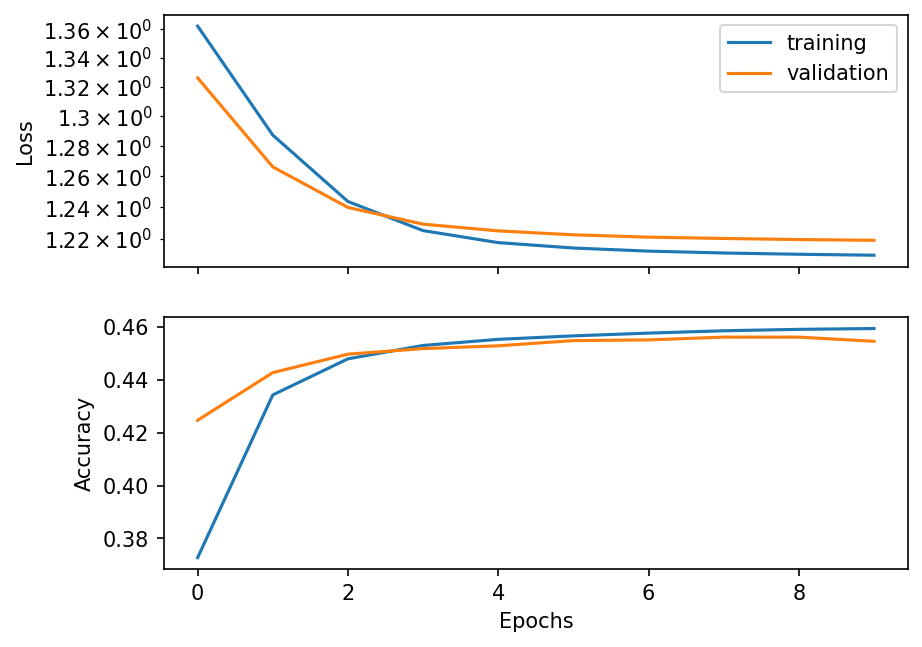

In [ ]:
utils.plot_history(history)

4 - GRU Model

In [ ]:
def build_gru_model(hidden_size):
  input = layers.Input(shape=(1,), dtype=tf.int64)
  x = layers.Embedding(input_dim= len(vocab),output_dim= 4)(input)
  x = utils.TruncateLayer(max_length=50)(x)
  x = layers.GRU(hidden_size)(x)
  output = layers.Dense(len(class_names), activation='softmax')(x)

  model = tf.keras.models.Model(input, output)
  model.compile(
      loss=SparseCategoricalCrossentropy(),
      optimizer=Adam(),
      metrics=[SparseCategoricalAccuracy()]
  )

  print(model.summary())

  return model

In [ ]:
def train_gru():
  hidden_sizes=[16, 32, 64] #this will be used as the associated label for the plot
  histories = []


  for h in hidden_sizes:
    gru_model = build_gru_model(h)
    history = gru_model.fit(train_ds_opt, validation_data= val_ds_opt,epochs=10)
    histories.append(history)

  return histories,hidden_sizes

In [ ]:
histories, hidden_sizes = train_gru()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 1, 4)              156       
                                                                 
 truncate_layer_1 (Truncate  (None, 1, 4)              0         
 Layer)                                                          
                                                                 
 gru (GRU)                   (None, 16)                1056      
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 1280 (5.00 KB)
Trainable params: 1280 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

In [ ]:
utils.plot_multiple_histories??

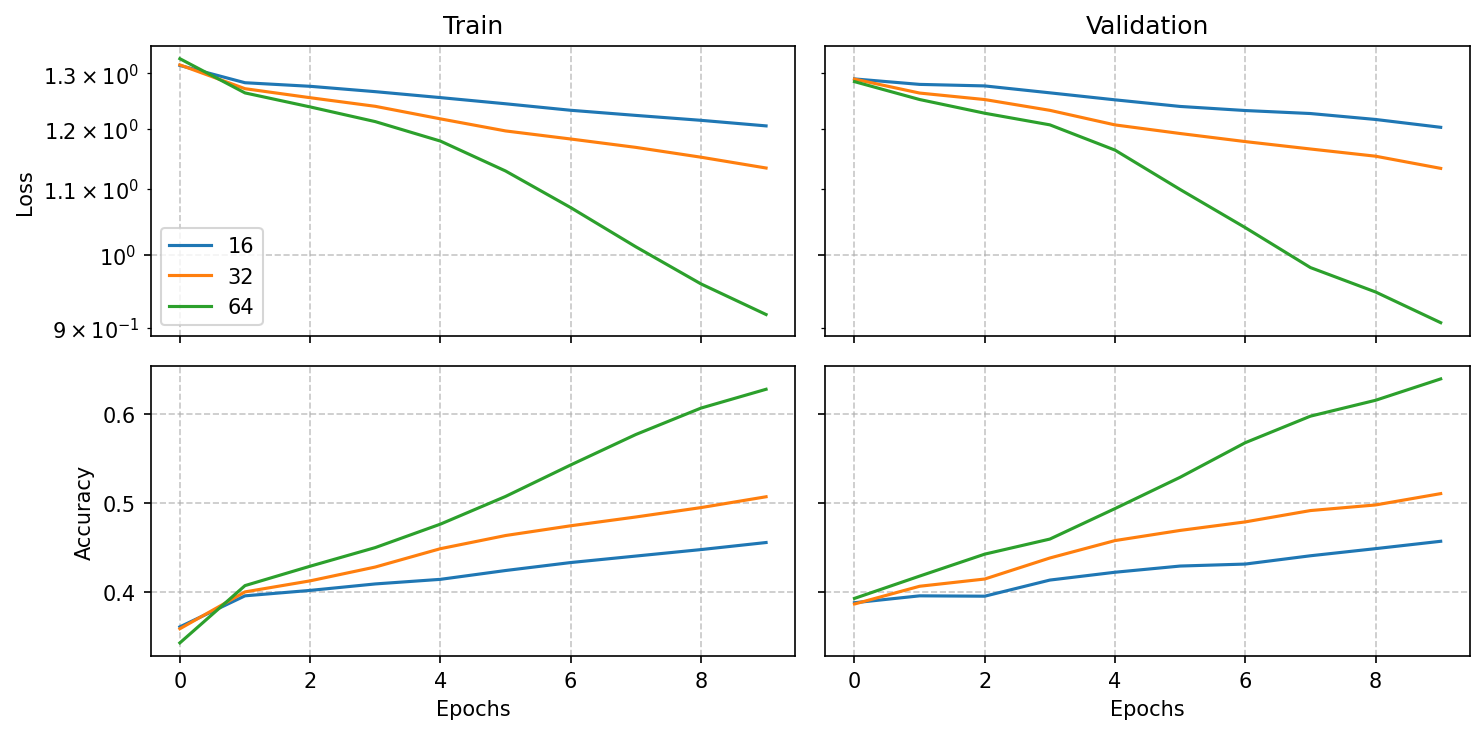

In [ ]:
utils.plot_multiple_histories(histories, hidden_sizes)

5 - Stacked GRUs

In [ ]:
def build_gru_model(gru_layers):
  input = layers.Input(shape=(1,), dtype=tf.int64)
  print('input layer paseed')
  x = layers.Embedding(input_dim= len(vocab),output_dim= 4)(input)
  x = utils.TruncateLayer(max_length=50)(x)
  for _ in range(gru_layers-1):
    x = layers.GRU(16, return_sequences= True)(x)    #the addition of return sequences in all but last GRU was explained by gemini
    print('GRU layer paseed')

  x = layers.GRU(16)(x)
  output = layers.Dense(len(class_names), activation='softmax')(x)

  model = tf.keras.models.Model(input, output)
  model.compile(
      loss=SparseCategoricalCrossentropy(),
      optimizer=Adam(),
      metrics=[SparseCategoricalAccuracy()]
  )

  print(model.summary())

  return model

In [ ]:
def train_stacked_gru():
  gru_layers = [2,3,4] #this will be used to label the models accordingly
  histories = []

  for k in gru_layers:
    gru_model = build_gru_model(k)
    history = gru_model.fit(train_ds_opt, validation_data= val_ds_opt,epochs=10)
    histories.append(history)

  return histories,gru_layers


In [ ]:
histories, gru_layers = train_stacked_gru()

input layer paseed
GRU layer paseed
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_4 (Embedding)     (None, 1, 4)              156       
                                                                 
 truncate_layer_4 (Truncate  (None, 1, 4)              0         
 Layer)                                                          
                                                                 
 gru_3 (GRU)                 (None, 1, 16)             1056      
                                                                 
 gru_4 (GRU)                 (None, 16)                1632      
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                       

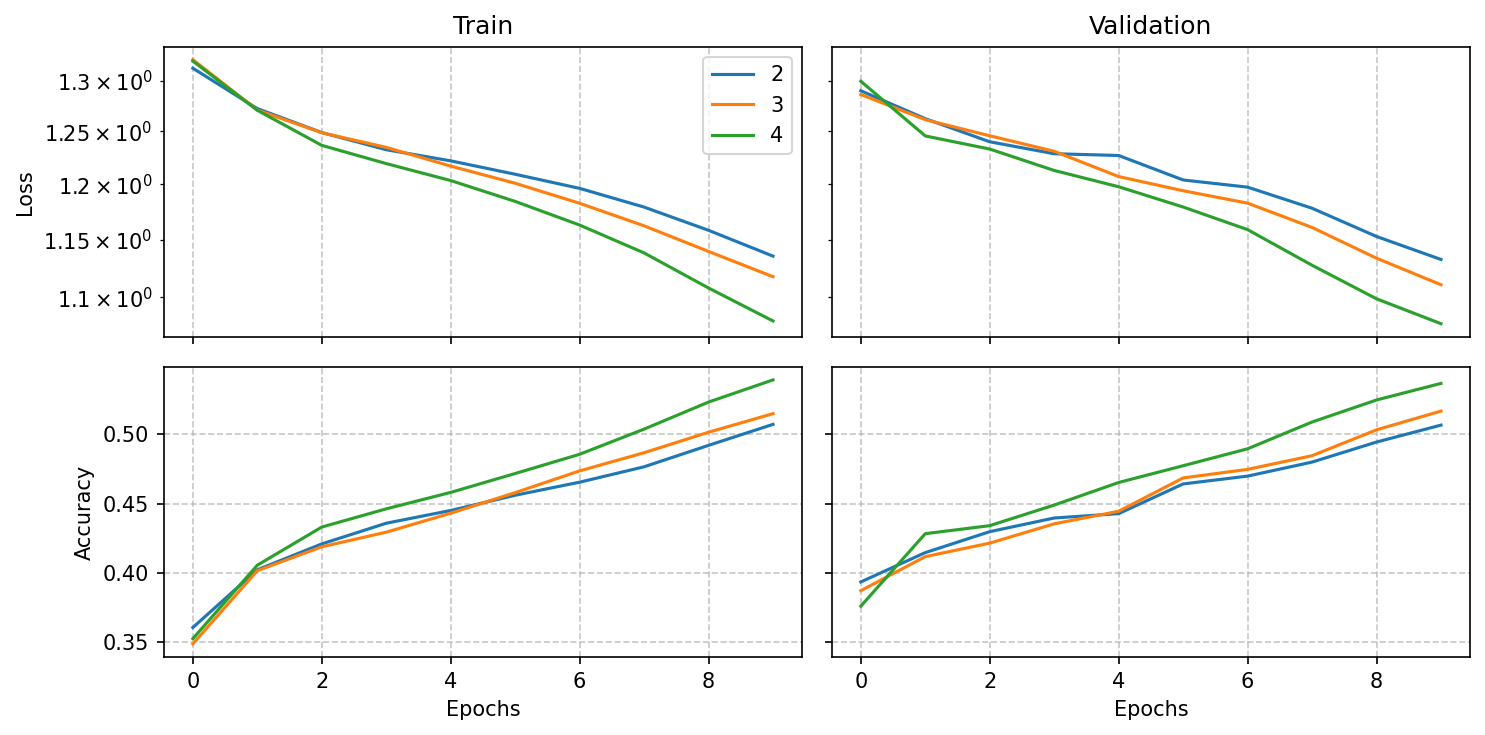

In [ ]:
utils.plot_multiple_histories(histories, gru_layers)

6 - Stacked GRUs with skip connections

In [ ]:
len(vocab)

39

In [ ]:
def build_gru_model_with_skip():

  input = layers.Input(shape=(1,), dtype=tf.int64)
  x = layers.Embedding(input_dim=len(vocab),output_dim= len(vocab) )(input)
  x = utils.TruncateLayer(max_length=100)(x)
  x_g1 = layers.GRU(len(vocab),return_sequences= True)(x)
  x = layers.Add()([x_g1])
  x_g2 = layers.GRU(len(vocab),return_sequences= True)(x)
  x = layers.Add()([x_g2])
  x_g3 = layers.GRU(len(vocab))(x)
  x = layers.Add()([x_g3])
  output = layers.Dense(len(class_names), activation='softmax')(x)

  model = tf.keras.models.Model(input, output)
  model.compile(
      loss=SparseCategoricalCrossentropy(),
      optimizer=Adam(),
      metrics=[SparseCategoricalAccuracy()]
  )

  print(model.summary())

  return model

In [ ]:
skip_model = build_gru_model_with_skip()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_7 (Embedding)     (None, 1, 4)              156       
                                                                 
 truncate_layer_7 (Truncate  (None, 1, 4)              0         
 Layer)                                                          
                                                                 
 gru_12 (GRU)                (None, 1, 39)             5265      
                                                                 
 add (Add)                   (None, 1, 39)             0         
                                                                 
 gru_13 (GRU)                (None, 1, 39)             9360      
                                                           

::A variable 'gru_sums' was used to accumulate the outputs of the GRU layers. Thereafter, the current GRU layer's output and the gru_sums are passed to a list which serves as input to the skip connection (i.e. Add layer). The return_sequence parameter of the GRU layer was to True

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='auto',

)

reduceLROP = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    mode='auto',
)

skip_history = skip_model.fit(train_ds_opt, validation_data= val_ds_opt,epochs=50, callbacks=[early_stopping, reduceLROP])

In [ ]:
def build_gru_model_with_skip():



  input = layers.Input(shape=(1,), dtype=tf.int64)
  x = layers.Embedding(input_dim=len(vocab),output_dim= 4)(input)
  x = utils.TruncateLayer(max_length=100)(x)
  x = layers.GRU(len(vocab),return_sequences= True)(x)
  x = layers.GRU(len(vocab),return_sequences= True)(x)
  x = layers.GRU(len(vocab))(x)
  output = layers.Dense(len(class_names), activation='softmax')(x)

  model = tf.keras.models.Model(input, output)
  model.compile(
      loss=SparseCategoricalCrossentropy(),
      optimizer=Adam(),
      metrics=[SparseCategoricalAccuracy()]
  )

  print(model.summary())

  return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='auto',

)

reduceLROP = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    mode='auto',
)

no_skip_history_model = build_gru_model_with_skip()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 1)]               0         
                                                                 
 embedding_29 (Embedding)    (None, 1, 4)              156       
                                                                 
 truncate_layer_28 (Truncat  (None, 1, 4)              0         
 eLayer)                                                         
                                                                 
 gru_46 (GRU)                (None, 1, 39)             5265      
                                                                 
 gru_47 (GRU)                (None, 1, 39)             9360      
                                                                 
 gru_48 (GRU)                (None, 39)                9360      
                                                          

In [ ]:
no_skip_history = no_skip_history_model.fit(train_ds_opt, validation_data= val_ds_opt,epochs=50, callbacks=[early_stopping, reduceLROP])

Epoch 1/50
938/938 [==============================] - 19s 16ms/step - loss: 1.3181 - sparse_categorical_accuracy: 0.3510 - val_loss: 1.2535 - val_sparse_categorical_accuracy: 0.4187 - lr: 0.0010
Epoch 2/50
938/938 [==============================] - 13s 14ms/step - loss: 1.2379 - sparse_categorical_accuracy: 0.4285 - val_loss: 1.2279 - val_sparse_categorical_accuracy: 0.4380 - lr: 0.0010
Epoch 3/50
938/938 [==============================] - 13s 14ms/step - loss: 1.2149 - sparse_categorical_accuracy: 0.4391 - val_loss: 1.2156 - val_sparse_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 4/50
938/938 [==============================] - 13s 14ms/step - loss: 1.1734 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.1560 - val_sparse_categorical_accuracy: 0.4739 - lr: 0.0010
Epoch 5/50
938/938 [==============================] - 14s 15ms/step - loss: 1.1190 - sparse_categorical_accuracy: 0.5048 - val_loss: 1.0748 - val_sparse_categorical_accuracy: 0.5388 - lr: 0.0010
Epoch 6/50
938/938 [=====

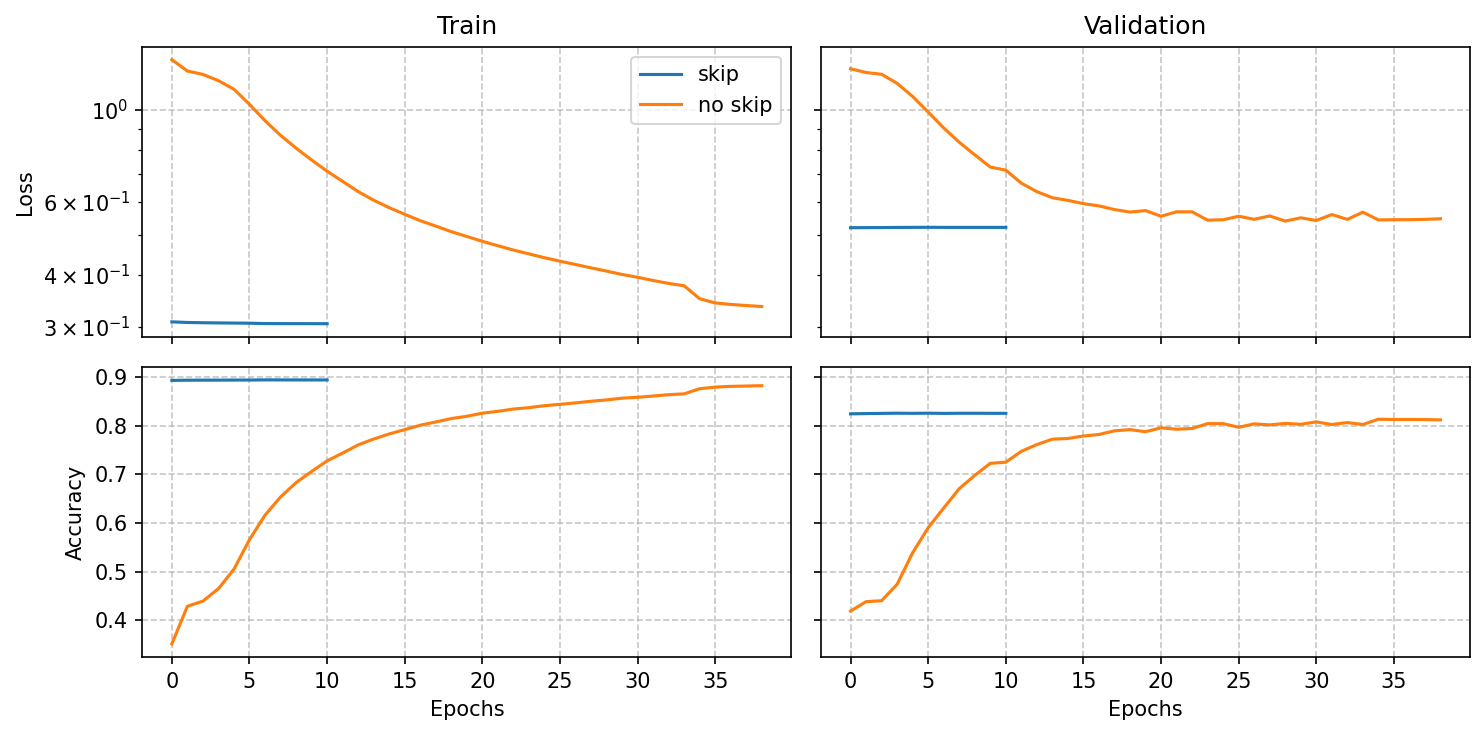

In [ ]:
utils.plot_multiple_histories([skip_history,no_skip_history],['skip','no skip'])